In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!ls '/content/drive'


MyDrive  Othercomputers


In [ ]:
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
import torch 
import numpy as np 

def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [ ]:
#Give dataset path
train_path = '/content/drive/MyDrive/DR_Datasets/Severity_Levels_Dataset/Train'
test_path = '/content/drive/MyDrive/DR_Datasets/Severity_Levels_Dataset/Test'

Working with 120 images
Image examples: 
Copy of 2D R P R KANTHAMMA_G_01-01-1953_0662_(0016).jpg


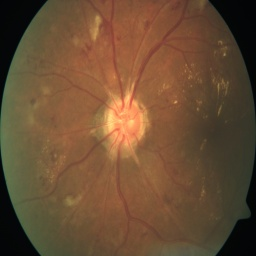

Copy of 2D R P R KANTHAMMA_G_01-01-1953_0662_(0021).jpg


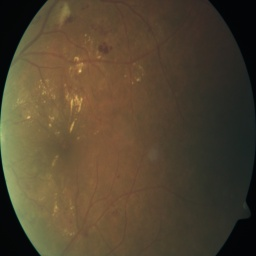

Copy of 2D R P R KANTHAMMA_G_01-01-1953_0662_(0024).jpg


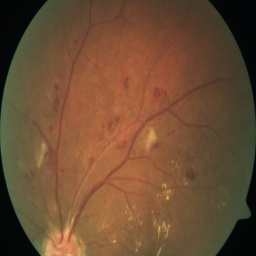

Copy of 2D R P R KANTHAMMA_G_01-01-1953_0662_(0022).jpg


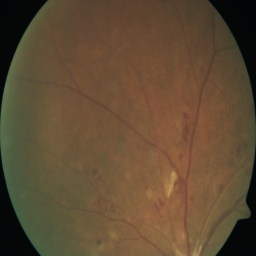

Copy of 2D R P R KANTHAMMA_G_01-01-1953_0662_(0019).jpg


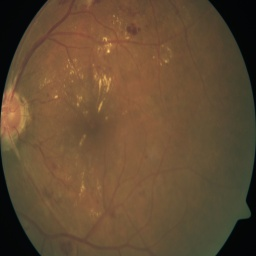

Copy of 2D R P R KANTHAMMA_G_01-01-1953_0662_(0025).jpg


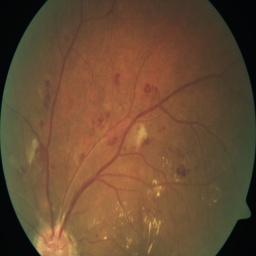

Copy of 2D R P R KANTHAMMA_G_01-01-1953_0662_(0023).jpg


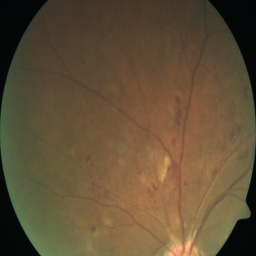

Copy of 2D R P R KANTHAMMA_G_01-01-1953_0662_(0017).jpg


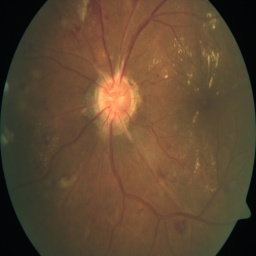

Copy of 2D R P R KANTHAMMA_G_01-01-1953_0662_(0020).jpg


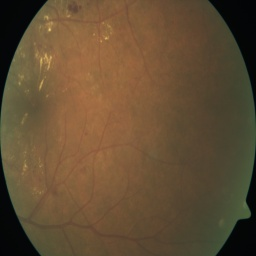

Copy of 2D R P R KANTHAMMA_G_01-01-1953_0662_(0018).jpg


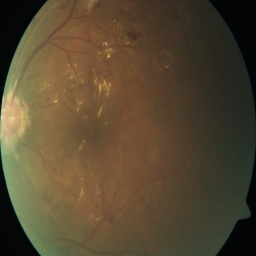

In [ ]:
from PIL import Image 
import os 
from IPython.display import display
from IPython.display import Image as _Imgdis
# creating a object  

  
folder = train_path+'/PDR'


onlybenignfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} images".format(len(onlybenignfiles)))
print("Image examples: ")


for i in range(10):
    print(onlybenignfiles[i])
    display(_Imgdis(filename=folder + "/" + onlybenignfiles[i], width=240, height=240))

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
folders = glob('/content/drive/MyDrive/DR_Datasets/Severity_Levels_Dataset/Train/*')
print(len(folders))

5


In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy',f1_m,precision_m])

In [ ]:
from torchvision import transforms as T,datasets

In [ ]:
class CFG:

  epochs =20                              # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  batch_size = 16                         # Batch Size for Dataset

  model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  img_size = 224                          # Resize all the images to be 224 by 224

  # going to be used for loading dataset
  train_path = '/content/drive/MyDrive/DR_Datasets/Severity_Levels_Dataset/Train'
  test_path = '/content/drive/MyDrive/DR_Datasets/Severity_Levels_Dataset/Test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [ ]:
train_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
                             T.RandomHorizontalFlip(p=0.1)
                             
                              # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [ ]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  1387


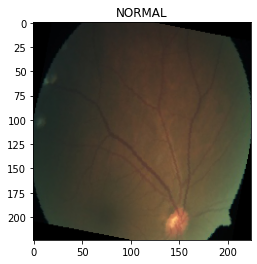

In [ ]:
img,label = trainset[0]
#print(trainset.class_to_idx)

class_name =["NORMAL","DR"]
show_image(img,class_name[label])

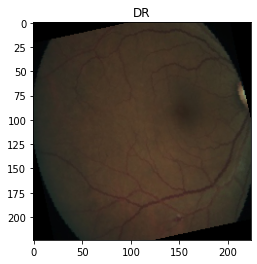

In [ ]:
img,label = trainset[222]
#print(trainset.class_to_idx)

class_name =["NORMAL","DR"]
show_image(img,class_name[label])

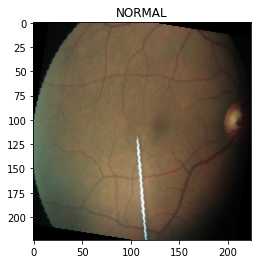

In [ ]:
img,label = trainset[23]
#print(trainset.class_to_idx)

class_name =["NORMAL","PNEUMONIA"]
show_image(img,class_name[label])

In [ ]:
train_transform = T.Compose([
                             
                             #T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             #T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             #T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
                             T.RandomHorizontalFlip(p=0.01)])
                             
                              # Normalize by 3 means 3 StD's of the image net, 3 channels

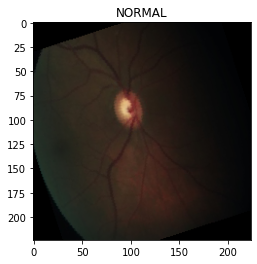

In [ ]:
img,label = trainset[21]
#print(trainset.class_to_idx)

class_name =["NORMAL","DR"]
show_image(img,class_name[label])

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False)

In [ ]:
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1387 images belonging to 5 classes.


In [ ]:
print(train_set.class_indices)

{'Mild': 0, 'Moderate': 1, 'NoDR': 2, 'PDR': 3, 'Severe': 4}


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 434 images belonging to 5 classes.


In [ ]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
#from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
#from keras.utils import Sequence
#from keras.utils import to_categorical
#from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 224
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

In [ ]:
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


#metric = 'val_accuracy'
#checkpoint = ModelCheckpoint(filepath='mymodel.h5',montior=metric,
                               #verbose=2, save_best_only=True,mode='max')

#callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(train_set,validation_data=test_set,epochs=15,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
44/44 [==============================] - 386s 8s/step - loss: 16.2144 - accuracy: 0.5624 - f1_m: 0.5622 - precision_m: 0.5622 - val_loss: 15.3380 - val_accuracy: 0.5438 - val_f1_m: 0.5494 - val_precision_m: 0.5494
Epoch 2/15
44/44 [==============================] - 26s 601ms/step - loss: 8.2008 - accuracy: 0.6972 - f1_m: 0.6990 - precision_m: 0.6990 - val_loss: 22.7719 - val_accuracy: 0.5899 - val_f1_m: 0.5905 - val_precision_m: 0.5905
Epoch 3/15
44/44 [==============================] - 26s 589ms/step - loss: 8.5134 - accuracy: 0.6965 - f1_m: 0.6983 - precision_m: 0.6983 - val_loss: 16.3798 - val_accuracy: 0.5668 - val_f1_m: 0.5647 - val_precision_m: 0.5647
Epoch 4/15
44/44 [==============================] - 26s 585ms/step - loss: 9.9276 - accuracy: 0.7130 - f1_m: 0.7078 - precision_m: 0.7078 - val_loss: 19.3566 - val_accuracy: 0.5576 - val_f1_m: 0.5593 - val_precision_m: 0.5593
Epoch 5/15
44/44 [==============================] - 26s 584ms/step - loss: 7.6157 - accuracy: 0.7

In [ ]:
from tensorflow.keras.regularizers import l2


In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(5, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'squared_hinge', metrics = ['accuracy',recall_m,precision_m])


In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


#metric = 'val_accuracy'
#checkpoint = ModelCheckpoint(filepath='mymodel.h5',montior=metric,
                               #verbose=2, save_best_only=True,mode='max')

#callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=15,
    #callbacks=callbacks ,
    verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
44/44 [==============================] - 28s 607ms/step - loss: 1.7701 - accuracy: 0.2942 - recall_m: 0.2938 - precision_m: 0.2945 - val_loss: 1.4155 - val_accuracy: 0.4585 - val_recall_m: 0.4598 - val_precision_m: 0.4598
Epoch 2/15
44/44 [==============================] - 26s 599ms/step - loss: 1.4519 - accuracy: 0.2898 - recall_m: 0.2896 - precision_m: 0.2896 - val_loss: 1.2645 - val_accuracy: 0.4585 - val_recall_m: 0.4668 - val_precision_m: 0.4668
Epoch 3/15
44/44 [==============================] - 26s 592ms/step - loss: 1.3858 - accuracy: 0.2898 - recall_m: 0.2896 - precision_m: 0.2896 - val_loss: 1.2421 - val_accuracy: 0.4585 - val_recall_m: 0.4598 - val_precision_m: 0.4598
Epoch 4/15
44/44 [==============================] - 26s 585ms/step - loss: 1.3736 - accuracy: 0.2898 - recall_m: 0.2896 - precision_m: 0.2896 - val_loss: 1.2364 - val_accuracy: 0.4585 - val_recall_m: 0.4616 - val_precision_m: 0.4616
Epoch 5/15
44/44 [==============================] - 26s 583ms/step -

In [ ]:
tf.keras.models.save_model(model,'my_model2.hdf5')


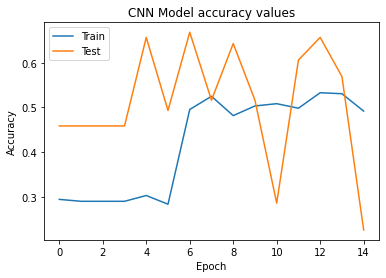

In [ ]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
from keras.applications.resnet import ResNet50

In [ ]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(resnet.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=prediction)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy',f1_m,precision_m])

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


#metric = 'val_accuracy'
#checkpoint = ModelCheckpoint(filepath='mymodel.h5',montior=metric,
                               #verbose=2, save_best_only=True,mode='max')

#callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=10,
    #callbacks=callbacks ,
    verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
44/44 [==============================] - 33s 634ms/step - loss: 18.4242 - accuracy: 0.5912 - f1_m: 0.5859 - precision_m: 0.5862 - val_loss: 18.5699 - val_accuracy: 0.6129 - val_f1_m: 0.6198 - val_precision_m: 0.6198
Epoch 2/10
44/44 [==============================] - 26s 584ms/step - loss: 10.8747 - accuracy: 0.7275 - f1_m: 0.7261 - precision_m: 0.7261 - val_loss: 18.6851 - val_accuracy: 0.5829 - val_f1_m: 0.5821 - val_precision_m: 0.5821
Epoch 3/10
44/44 [==============================] - 26s 583ms/step - loss: 11.2212 - accuracy: 0.7130 - f1_m: 0.7146 - precision_m: 0.7146 - val_loss: 16.8762 - val_accuracy: 0.6959 - val_f1_m: 0.7019 - val_precision_m: 0.7019
Epoch 4/10
44/44 [==============================] - 26s 584ms/step - loss: 9.1298 - accuracy: 0.7787 - f1_m: 0.7779 - precision_m: 0.7779 - val_loss: 14.1153 - val_accuracy: 0.6705 - val_f1_m: 0.6687 - val_precision_m: 0.6687
Epoch 5/10
44/44 [==============================] - 26s 583ms/step - loss: 9.3478 - accuracy:

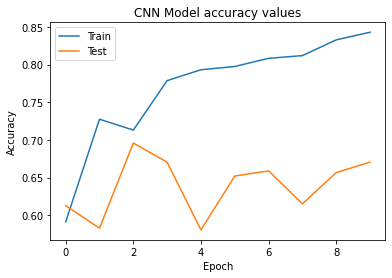

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from keras.applications.inception_v3 import InceptionV3


In [ ]:
inceptionv3 = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
inceptionv3.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_4')>

In [ ]:
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(inceptionv3.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=inceptionv3.input, outputs=prediction)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy',f1_m,precision_m])

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


#metric = 'val_accuracy'
#checkpoint = ModelCheckpoint(filepath='mymodel.h5',montior=metric,
                               #verbose=2, save_best_only=True,mode='max')

#callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=15,
    #callbacks=callbacks ,
    verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
44/44 [==============================] - 48s 831ms/step - loss: 1.5867 - accuracy: 0.2862 - f1_m: 0.1109 - precision_m: 0.4299 - val_loss: 424096143769600.0000 - val_accuracy: 0.4585 - val_f1_m: 0.4563 - val_precision_m: 0.4563
Epoch 2/15
44/44 [==============================] - 31s 705ms/step - loss: 0.4661 - accuracy: 0.3180 - f1_m: 0.0936 - precision_m: 0.9773 - val_loss: 437278816.0000 - val_accuracy: 0.4585 - val_f1_m: 0.4616 - val_precision_m: 0.4616
Epoch 3/15
44/44 [==============================] - 31s 707ms/step - loss: 0.6255 - accuracy: 0.3922 - f1_m: 0.2209 - precision_m: 0.8485 - val_loss: 180503.8906 - val_accuracy: 0.4585 - val_f1_m: 0.4581 - val_precision_m: 0.4581
Epoch 4/15
44/44 [==============================] - 31s 705ms/step - loss: 0.8227 - accuracy: 0.3136 - f1_m: 0.1011 - precision_m: 0.6280 - val_loss: 4758.1152 - val_accuracy: 0.4585 - val_f1_m: 0.4546 - val_precision_m: 0.4546
Epoch 5/15
44/44 [==============================] - 31s 702ms/step - l

In [ ]:
from keras.applications.mobilenet import MobileNet

In [ ]:
mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(mobilenet.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=mobilenet.input, outputs=prediction)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy',f1_m,precision_m])

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


#metric = 'val_accuracy'
#checkpoint = ModelCheckpoint(filepath='mymodel.h5',montior=metric,
                               #verbose=2, save_best_only=True,mode='max')

#callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=15,
    #callbacks=callbacks ,
    verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
44/44 [==============================] - 34s 633ms/step - loss: 3.5183 - accuracy: 0.3778 - f1_m: 0.2960 - precision_m: 0.5565 - val_loss: 69.6142 - val_accuracy: 0.2166 - val_f1_m: 0.2220 - val_precision_m: 0.2220
Epoch 2/15
44/44 [==============================] - 27s 607ms/step - loss: 0.7817 - accuracy: 0.4823 - f1_m: 0.4241 - precision_m: 0.6430 - val_loss: 38.5058 - val_accuracy: 0.1820 - val_f1_m: 0.1781 - val_precision_m: 0.1781
Epoch 3/15
44/44 [==============================] - 27s 606ms/step - loss: 0.9893 - accuracy: 0.5487 - f1_m: 0.5082 - precision_m: 0.6650 - val_loss: 10.9914 - val_accuracy: 0.6267 - val_f1_m: 0.6280 - val_precision_m: 0.6280
Epoch 4/15
44/44 [==============================] - 27s 605ms/step - loss: 0.5163 - accuracy: 0.5652 - f1_m: 0.5211 - precision_m: 0.7114 - val_loss: 7.8338 - val_accuracy: 0.5207 - val_f1_m: 0.5201 - val_precision_m: 0.5201
Epoch 5/15
44/44 [==============================] - 27s 605ms/step - loss: 0.6006 - accuracy: 0.5

In [ ]:
DenseNet=tf.keras.applications.DenseNet201(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

In [ ]:
x = Flatten()(DenseNet.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=DenseNet.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy',f1_m,precision_m])

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


#metric = 'val_accuracy'
#checkpoint = ModelCheckpoint(filepath='mymodel.h5',montior=metric,
                               #verbose=2, save_best_only=True,mode='max')

#callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=15,
    #callbacks=callbacks ,
    verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
44/44 [==============================] - 98s 2s/step - loss: 0.5804 - accuracy: 0.4867 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.5341 - val_accuracy: 0.2166 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/15
44/44 [==============================] - 56s 1s/step - loss: 0.4630 - accuracy: 0.5083 - f1_m: 0.1260 - precision_m: 0.2506 - val_loss: 0.5129 - val_accuracy: 0.2166 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/15
44/44 [==============================] - 56s 1s/step - loss: 0.4213 - accuracy: 0.5148 - f1_m: 0.4064 - precision_m: 0.8545 - val_loss: 0.4611 - val_accuracy: 0.4585 - val_f1_m: 0.4668 - val_precision_m: 0.4668
Epoch 4/15
44/44 [==============================] - 55s 1s/step - loss: 0.3921 - accuracy: 0.5299 - f1_m: 0.4310 - precision_m: 0.8955 - val_loss: 0.4645 - val_accuracy: 0.4747 - val_f1_m: 0.4638 - val_precision_m: 0.4718
Epoch 5/15
44/44 [==============================] - 55s 1s/step - loss: 0.3798 - accurac

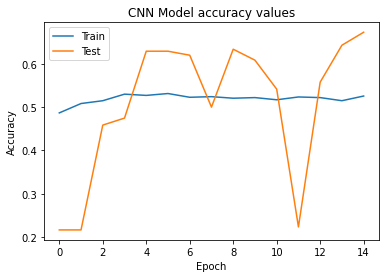

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#from keras.applications.Alexnet import AlexNet
# Creates AlexNet for 5 classes
Alexnet = torchvision.models.alexnet(num_classes=5)

In [ ]:
import keras
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax')
])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy',f1_m,precision_m])

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


#metric = 'val_accuracy'
#checkpoint = ModelCheckpoint(filepath='mymodel.h5',montior=metric,
                               #verbose=2, save_best_only=True,mode='max')

#callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=15,
    #callbacks=callbacks ,
    verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
44/44 [==============================] - 330s 7s/step - loss: 136.2410 - accuracy: 0.4110 - f1_m: 0.4098 - precision_m: 0.4102 - val_loss: 459.6278 - val_accuracy: 0.5668 - val_f1_m: 0.5665 - val_precision_m: 0.5665
Epoch 2/15
44/44 [==============================] - 23s 524ms/step - loss: 9.9281 - accuracy: 0.4319 - f1_m: 0.4321 - precision_m: 0.4477 - val_loss: 12.6092 - val_accuracy: 0.5000 - val_f1_m: 0.4965 - val_precision_m: 0.4965
Epoch 3/15
44/44 [==============================] - 23s 517ms/step - loss: 1.7764 - accuracy: 0.4283 - f1_m: 0.4049 - precision_m: 0.5053 - val_loss: 0.4295 - val_accuracy: 0.5714 - val_f1_m: 0.4198 - val_precision_m: 0.6378
Epoch 4/15
44/44 [==============================] - 23s 516ms/step - loss: 1.5693 - accuracy: 0.4542 - f1_m: 0.3953 - precision_m: 0.5978 - val_loss: 0.4234 - val_accuracy: 0.3986 - val_f1_m: 0.2978 - val_precision_m: 0.8323
Epoch 5/15
44/44 [==============================] - 23s 522ms/step - loss: 0.7343 - accuracy: 0.3

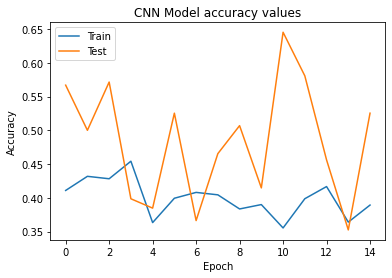

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
NASNet=tf.keras.applications.NASNetMobile(
    input_shape=None,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
)

24240128/24227760 [==============================] - 0s 0us/step


In [ ]:
x = Flatten()(NASNet.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=NASNet.input, outputs=prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy',f1_m,precision_m])

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


#metric = 'val_accuracy'
#checkpoint = ModelCheckpoint(filepath='mymodel.h5',montior=metric,
                               #verbose=2, save_best_only=True,mode='max')

#callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=15,
    #callbacks=callbacks ,
    verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
44/44 [==============================] - 69s 928ms/step - loss: 0.5855 - accuracy: 0.4218 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.5273 - val_accuracy: 0.2166 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/15
44/44 [==============================] - 36s 804ms/step - loss: 0.4756 - accuracy: 0.4859 - f1_m: 0.0661 - precision_m: 0.1235 - val_loss: 0.5076 - val_accuracy: 0.2166 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/15
44/44 [==============================] - 36s 802ms/step - loss: 0.4407 - accuracy: 0.4795 - f1_m: 0.3654 - precision_m: 0.7664 - val_loss: 0.5139 - val_accuracy: 0.2166 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 4/15
44/44 [==============================] - 36s 803ms/step - loss: 0.4035 - accuracy: 0.5148 - f1_m: 0.4186 - precision_m: 0.8513 - val_loss: 0.4650 - val_accuracy: 0.4585 - val_f1_m: 0.4529 - val_precision_m: 0.4529
Epoch 5/15
44/44 [==============================] - 36s 800ms/step -

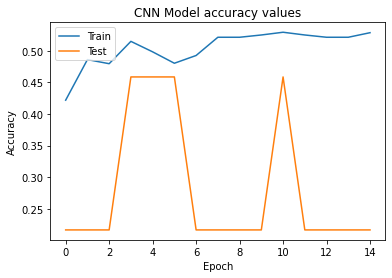

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
EffNet=tf.keras.applications.EfficientNetB2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

37445632/37432240 [==============================] - 0s 0us/step


In [ ]:
x = Flatten()(NASNet.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=NASNet.input, outputs=prediction)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy',f1_m,precision_m])

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


#metric = 'val_accuracy'
#checkpoint = ModelCheckpoint(filepath='mymodel.h5',montior=metric,
                               #verbose=2, save_best_only=True,mode='max')

#callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=15,
    #callbacks=callbacks ,
    verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
44/44 [==============================] - 68s 908ms/step - loss: 0.5882 - accuracy: 0.4448 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.5463 - val_accuracy: 0.2166 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/15
44/44 [==============================] - 36s 803ms/step - loss: 0.4684 - accuracy: 0.5263 - f1_m: 0.0905 - precision_m: 0.1732 - val_loss: 0.5191 - val_accuracy: 0.2166 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/15
44/44 [==============================] - 36s 798ms/step - loss: 0.4298 - accuracy: 0.5032 - f1_m: 0.3978 - precision_m: 0.8825 - val_loss: 0.4601 - val_accuracy: 0.4585 - val_f1_m: 0.4598 - val_precision_m: 0.4598
Epoch 4/15
44/44 [==============================] - 35s 798ms/step - loss: 0.4069 - accuracy: 0.5083 - f1_m: 0.4045 - precision_m: 0.9060 - val_loss: 0.5292 - val_accuracy: 0.2166 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 5/15
44/44 [==============================] - 36s 801ms/step -

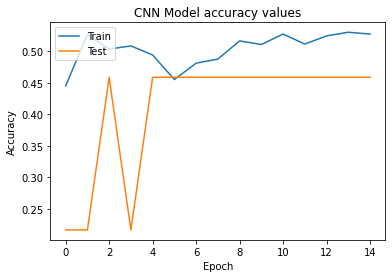

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()